# **Imports**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 26.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow.keras.backend as K
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

np.set_printoptions(suppress=True)
print(tf.__version__)

import shutil

from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

2.15.0


# **Analyzing and Preparing the Dataset**

In [ ]:
PATH = 'labeled_data.csv'
df = pd.read_csv(PATH)

In [ ]:
nRowsRead = None
df0 = pd.read_csv(PATH, delimiter=',', nrows = nRowsRead)
df0.dataframeName = 'labeled_data.csv'
nRow, nCol = df0.shape
print('There are {} rows and {} columns'.format(nRow, nCol))

There are 24783 rows and 7 columns


In [ ]:
df0.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
c=df0['class']
df0.rename(columns={'tweet' : 'text',
                   'class' : 'category'},
                    inplace=True)
a=df0['text']
b=df0['category'].map({0: 'hate_speech', 1: 'offensive_language',2: 'neither'})

df= pd.concat([a,b,c], axis=1)
df.rename(columns={'class' : 'label'},
                    inplace=True)
df

,text,category,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1
24779,"you've gone and broke the wrong heart baby, an...",neither,2
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1
24781,youu got wild bitches tellin you lies,offensive_language,1


In [ ]:
df.groupby('label').count()

,text,category
label,,
0,1430,1430
1,19190,19190
2,4163,4163


In [ ]:
hate, offensive, neither = np.bincount(df['label'])
total = hate + offensive + neither
print('Examples:\n    Total: {}\n    hate: {} ({:.2f}% of total)\n'.format(
    total, hate, 100 * hate / total))
print('Examples:\n    Total: {}\n    Ofensive: {} ({:.2f}% of total)\n'.format(
    total, offensive, 100 * offensive / total))
print('Examples:\n    Total: {}\n    Neither: {} ({:.2f}% of total)\n'.format(
    total, neither, 100 * neither / total))

Examples:
    Total: 24783
    hate: 1430 (5.77% of total)

Examples:
    Total: 24783
    Ofensive: 19190 (77.43% of total)

Examples:
    Total: 24783
    Neither: 4163 (16.80% of total)



# **Splitting the data**

In [ ]:
X_train_, X_test, y_train_, y_test = train_test_split(
    df.index.values,
    df.label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.label.values,
)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df.loc[X_train_].index.values,
    df.loc[X_train_].label.values,
    test_size=0.10,
    random_state=42,
    stratify=df.loc[X_train_].label.values,
)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

In [ ]:
df.groupby(['category', 'label', 'data_type']).count()

text
category           label data_type       
hate_speech        0     test         143
                         train       1158
                         val          129
neither            2     test         416
                         train       3372
                         val          375
offensive_language 1     test        1920
                         train      15543
                         val         1727

In [ ]:
df

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
...,...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,offensive_language,1,train
24779,"you've gone and broke the wrong heart baby, an...",neither,2,train
24780,young buck wanna eat!!.. dat nigguh like I ain...,offensive_language,1,train
24781,youu got wild bitches tellin you lies,offensive_language,1,train


In [ ]:
df_train = df.loc[df["data_type"]=="train"]
df_train.head(5)

,text,category,label,data_type
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,offensive_language,1,train
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,offensive_language,1,train
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,offensive_language,1,train
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,offensive_language,1,train
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",offensive_language,1,train


In [ ]:
df_val = df.loc[df["data_type"]=="val"]
df_val.head(5)

,text,category,label,data_type
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",offensive_language,1,val
27,""" i met that pussy on Ocean Dr . i gave that p...",offensive_language,1,val
31,""" i'd say im back to the old me but my old bit...",offensive_language,1,val
44,""" post a picture of that pussy get 200 likes """,offensive_language,1,val
46,""" quick piece of pussy call it a drive by """,offensive_language,1,val


In [ ]:
df_test = df.loc[df["data_type"]=="test"]
df_test.head(5)

,text,category,label,data_type
0,!!! RT @mayasolovely: As a woman you shouldn't...,neither,2,test
12,""" So hoes that smoke are losers ? "" yea ... go...",offensive_language,1,test
14,""" bitch get up off me """,offensive_language,1,test
17,""" bitch who do you love """,offensive_language,1,test
25,""" her pussy lips like Heaven doors "" &#128524;",offensive_language,1,test


In [ ]:
df.dtypes

text         object
category     object
label         int64
data_type    object
dtype: object

<class 'set'>


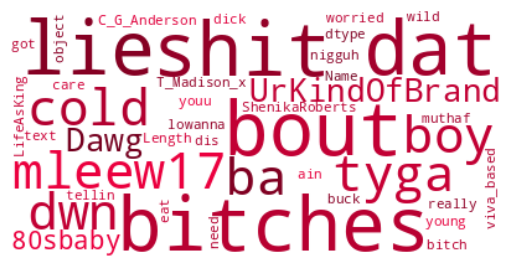

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add("RT")

print(type(STOPWORDS))

import random

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 344
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str(df.loc[df["category"]=="offensive_language"].text))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

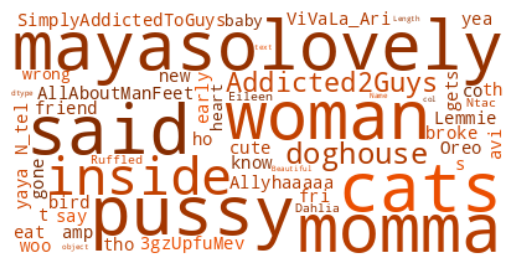

In [ ]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 20
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="neither"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

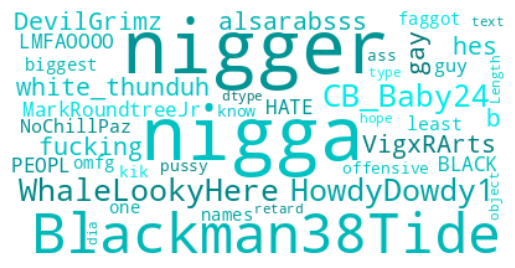

In [ ]:
stopwords.add("Name")

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 180
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=60,
                          random_state=42
                         ).generate(str((df.loc[df["category"]=="hate_speech"].text)))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(color_func= random_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()

# **Build TensorFlow Input**

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train.text.values, df_train.label.values))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.text.values, df_val.label.values))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.text.values, df_test.label.values))

In [ ]:
train_ds = train_ds.shuffle(len(df_train)).batch(32, drop_remainder=False)
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_ds = val_ds.shuffle(len(df_val)).batch(32, drop_remainder=False)
val_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_ds = test_ds.shuffle(len(df_test)).batch(32, drop_remainder=False)
test_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# **Printing Some Tweets**

In [ ]:
for feat, targ in train_ds.take(1):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [b'&#8220;@crystalinag: finger a bitch w/ my trigger finger&#8221; nigga shut up'
 b'@operationSAFE @GaltsGirl lived there and can attest to that. Trust them over any muzzie nation by a million light years'
 b"&#8220;@El_Grillo1: Islamic State suspects in Indonesia are Chinese Uighurs http://t.co/58IDicaHzT&#8221;\nUighur Jihadis: they're not just a PRC tool."
 b'stupid bitch&#8230;&#8230; count to H and get off my phone'
 b'Truth is @MaxOn_MaxOff5 ate yellow snow as a child..'
 b'This bitch is mad because her man cheated but she cheated too!!!! Why you mad?!!!'
 b'RT @GottaPHILMe: &#128128;&#128128; RT &#8220;@VersaceSilk: When you and your boys discover a hoe https://t.co/fbfR8trToY&#8221;'
 b'And them niggas pussies...cameltoes &#128514;'
 b"RT @1Armaun: Hoes get a boyfriend and swear they not a hoe anymore. Bitch Having a boyfriend doesn't erase what happened before him you ..."
 b'RT @BlackJeezuss: bitches cant finish a 6 inch sub but want a 12 inch dick'
 b'@Blackman38T

# **Loading models from TensorFlow Hub**

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


# **The preprocessing model**

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(1):
    tweet = text_batch.numpy()[i]
    print(f'Tweet: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

text_test = ['this is such an amazing movie!']
text_test = [tweet]


text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Tweet: b'RT @IAMMISSRAMIREZ: Charlie Sheen is the man lol http://t.co/FCfSbvAphh'
Label : 2
Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101 19387  1030 24264  7382 14643  6444  7442  2480  1024  4918 20682]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7570459   0.9970816   0.38265893  0.23998737  0.22947864  0.9720204
  0.9964762  -0.99686843 -0.15537949 -0.99171567  0.57432586 -0.9429778 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.3209052   0.48815644  0.66089195 ...  0.6447116  -0.02776454
  -0.24478671]
 [-0.6525698   0.15897985  0.31423935 ...  0.20106916  0.82781833
   0.41778663]
 [-0.2823654   0.8547588   0.34489882 ... -0.4594481  -0.9863657
   0.9982779 ]
 ...
 [-0.20828608  0.9989835   1.6420972  ...  0.60035384 -0.15968469
   0.0687711 ]
 [-0.9581684  -0.66759646  1.1848724  ...  0.04767744  0.05747547
  -0.3770752 ]
 [-1.425141    0.03505231  2.3018527  ...  0.7279955   0.9528745
  -0.8879424 ]]


# **Techniques to deal with unbalanced data**

In [ ]:
weight_for_0 = (1 / hate)*(total)/3.0
weight_for_1 = (1 / offensive)*(total)/3.0
weight_for_2 = (1 / neither)*(total)/3.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 5.78
Weight for class 1: 0.43
Weight for class 2: 1.98


In [ ]:
initial_output_bias = np.array([3.938462, 15, 5.])
initial_output_bias

array([ 3.938462, 15.      ,  5.      ])

# **BERT + MLP**

In [ ]:
def build_classifier_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        #print(output_bias)

    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(512, activation="relu")(net)
    net = tf.keras.layers.Dropout(0.2)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier', bias_initializer=output_bias)(net)

    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model(output_bias=initial_output_bias)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5000012  0.7310487  0.50001127]], shape=(1, 3), dtype=float32)


In [ ]:
classifier_model.get_weights()[-1]

array([ 3.938462, 15.      ,  5.      ], dtype=float32)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

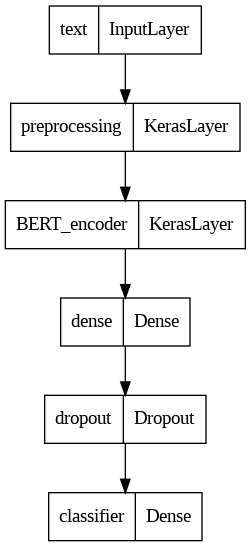

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

In [ ]:
epochs = 30
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


628/628 [==============================] - 156s 234ms/step - loss: 2.8419 - accuracy: 0.6892 - val_loss: 0.5692 - val_accuracy: 0.7436
Epoch 2/30
628/628 [==============================] - 146s 232ms/step - loss: 0.6588 - accuracy: 0.8001 - val_loss: 0.4730 - val_accuracy: 0.7992
Epoch 3/30
628/628 [==============================] - 146s 232ms/step - loss: 0.5400 - accuracy: 0.8444 - val_loss: 0.3893 - val_accuracy: 0.8503
Epoch 4/30
628/628 [==============================] - 145s 231ms/step - loss: 0.4480 - accuracy: 0.8673 - val_loss: 0.3374 - val_accuracy: 0.8669
Epoch 5/30
628/628 [==============================] - 146s 232ms/step - loss: 0.3643 - accuracy: 0.8899 - val_loss: 0.3451 - val_accuracy: 0.8826
Epoch 6/30
628/628 [==============================] - 146s 233ms/step - loss: 0.3006 - accuracy: 0.9141 - val_loss: 0.3976 - val_accuracy: 0.8669
Epoch 7/30
628/628 [==============================] - 149s 238ms/step - loss: 0.2260 - accuracy: 0.9369 - val_loss: 0.4011 - val_accura

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 8s 102ms/step - loss: 1.0829 - accuracy: 0.9048
Loss: 1.0829271078109741
Accuracy: 0.904800295829773


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


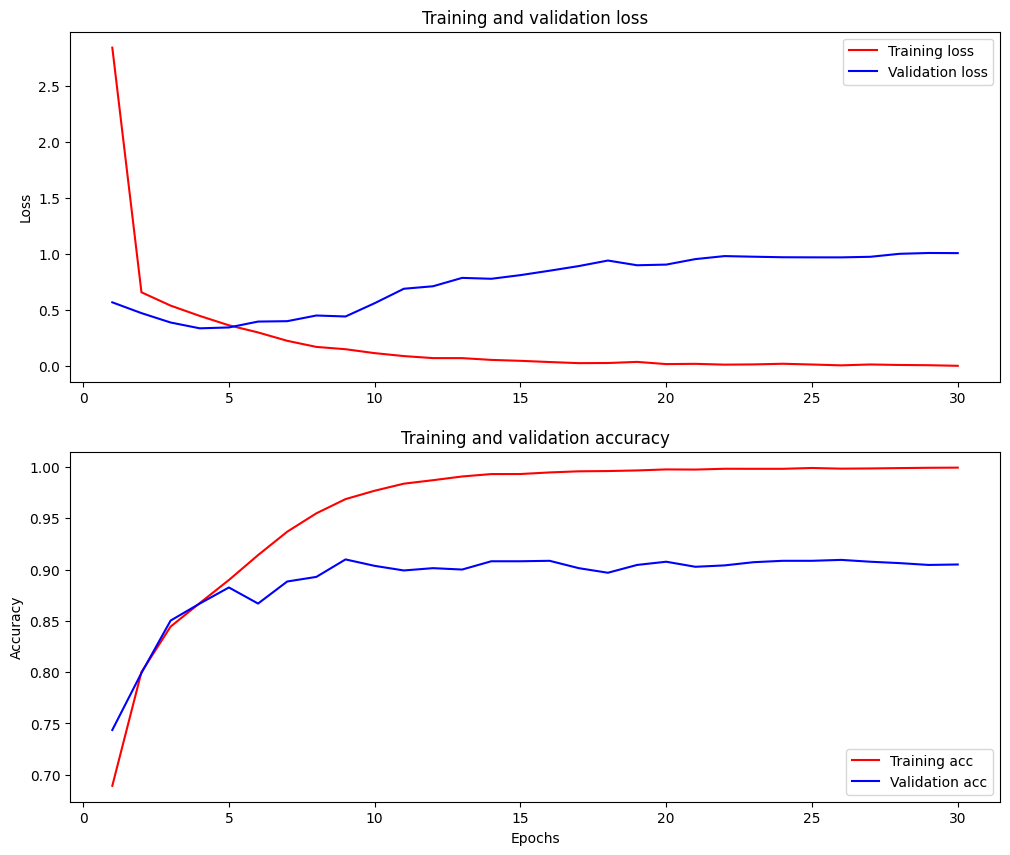

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'mpl_hate_speech'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

# **Result for MLP**

In [ ]:
result =  classifier_model.predict(test_ds)
print(result.shape)

78/78 [==============================] - 9s 111ms/step
(2479, 3)


In [ ]:
result[0:2]

array([[0.00000053, 0.99999917, 0.00000033],
       [0.00000036, 0.9999994 , 0.00000019]], dtype=float32)

In [ ]:
classes = np.argmax(result, axis=-1)

In [ ]:
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(classifier_model.predict(tweet))

1/1 [==============================] - 1s 687ms/step


In [ ]:
test_labels[0:2]

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 1]),
 array([1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1])]

In [ ]:
predictions[0:2]

[array([[0.0000005 , 0.9999993 , 0.00000023],
        [0.9946825 , 0.00531595, 0.00000155],
        [0.00000039, 0.9999995 , 0.00000017],
        [0.00000302, 0.9999964 , 0.00000055],
        [0.00000099, 0.9999988 , 0.00000025],
        [0.00006259, 0.99993634, 0.0000011 ],
        [0.00000125, 0.99999845, 0.00000027],
        [0.00000077, 0.99999917, 0.00000015],
        [0.9999652 , 0.0000346 , 0.00000028],
        [0.00000038, 0.9999995 , 0.00000017],
        [0.0009294 , 0.9990656 , 0.000005  ],
        [0.00000008, 0.00000101, 0.9999989 ],
        [0.28183725, 0.71814775, 0.000015  ],
        [0.00000053, 0.99999917, 0.00000031],
        [0.0000005 , 0.9999994 , 0.00000016],
        [0.00000028, 0.9999995 , 0.00000021],
        [0.00000007, 0.00000015, 0.99999976],
        [0.00000041, 0.9999995 , 0.00000015],
        [0.00000088, 0.9999988 , 0.00000037],
        [0.00022133, 0.9997769 , 0.00000176],
        [0.00000027, 0.99999964, 0.00000015],
        [0.00000016, 0.99999964, 0

In [ ]:
from itertools import chain
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [ ]:
y_test = np.array(list(chain.from_iterable(test_labels)))

# **Confusion Matrix MLP**

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  51,   84,    8],
       [  64, 1830,   26],
       [   6,   48,  362]])

In [ ]:
random_classifier_model = build_classifier_model()
bert_raw_result = random_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#metrics = tf.metrics.Accuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

random_classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

tf.Tensor([[0.61780006 0.6026101  0.5258336 ]], shape=(1, 3), dtype=float32)


In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
random_history = random_classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               # The class weights go here
                               class_weight=class_weight
)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


628/628 [==============================] - 154s 235ms/step - loss: 0.7800 - accuracy: 0.7108 - val_loss: 0.3580 - val_accuracy: 0.8512
Epoch 2/5
628/628 [==============================] - 148s 236ms/step - loss: 0.4967 - accuracy: 0.8532 - val_loss: 0.3410 - val_accuracy: 0.8610
Epoch 3/5
628/628 [==============================] - 146s 232ms/step - loss: 0.4181 - accuracy: 0.8771 - val_loss: 0.3673 - val_accuracy: 0.8655
Epoch 4/5
628/628 [==============================] - 145s 230ms/step - loss: 0.3498 - accuracy: 0.8937 - val_loss: 0.3180 - val_accuracy: 0.8888
Epoch 5/5
628/628 [==============================] - 144s 230ms/step - loss: 0.2956 - accuracy: 0.9074 - val_loss: 0.3354 - val_accuracy: 0.8839


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


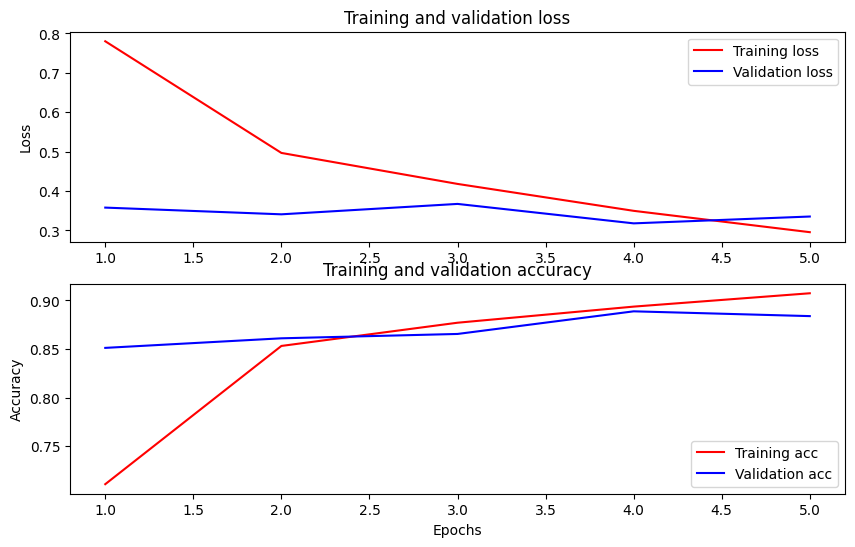

In [ ]:
history_dict = random_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# **BERT + CNN**

In [ ]:
def build_CNN_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    #net = outputs['pooled_output'] # [batch_size, 768].
    net = sequence_output = outputs["sequence_output"] # [batch_size, seq_length, 768]


    net = tf.keras.layers.Conv1D(32, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)

    net = tf.keras.layers.Conv1D(64, (2), activation='relu')(net)
    #net = tf.keras.layers.MaxPooling1D(2)(net)
    net = tf.keras.layers.GlobalMaxPool1D()(net)

#    net = tf.keras.layers.Flatten()(net)

    net = tf.keras.layers.Dense(512, activation="relu")(net)

    net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name='classifier')(net)

    return tf.keras.Model(text_input, net)

In [ ]:
cnn_classifier_model = build_CNN_classifier_model()
bert_raw_result = cnn_classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.61958855 0.58277863 0.5443847 ]], shape=(1, 3), dtype=float32)


In [ ]:
text_test

[b'RT @IAMMISSRAMIREZ: Charlie Sheen is the man lol http://t.co/FCfSbvAphh']

In [ ]:
cnn_classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                            

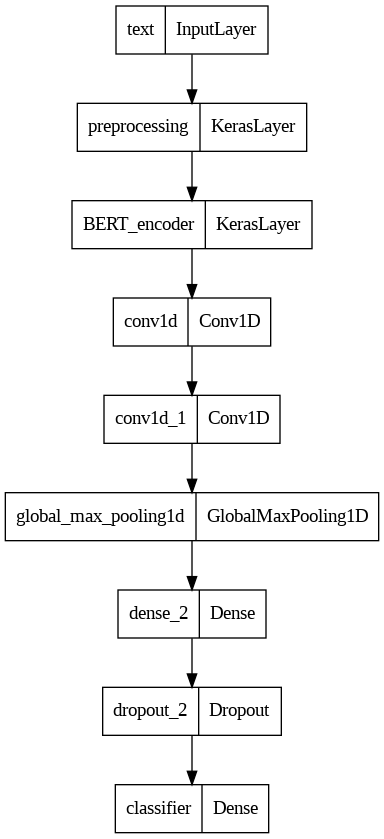

In [ ]:
tf.keras.utils.plot_model(cnn_classifier_model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#metrics = tf.metrics.CategoricalCrossentropy()
#metrics = tf.metrics.Accuracy()

In [ ]:
epochs = 30
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

cnn_classifier_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy'))

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
cnn_history = cnn_classifier_model.fit(x=train_ds,
                                       validation_data=val_ds,
                                       epochs=epochs,
                                       class_weight=class_weight
                                      )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/30
628/628 [==============================] - 155s 236ms/step - loss: 1.0708 - accuracy: 0.5080 - val_loss: 0.6016 - val_accuracy: 0.7956
Epoch 2/30
628/628 [==============================] - 149s 237ms/step - loss: 0.6178 - accuracy: 0.8138 - val_loss: 0.3328 - val_accuracy: 0.8736
Epoch 3/30
628/628 [==============================] - 148s 236ms/step - loss: 0.4966 - accuracy: 0.8434 - val_loss: 0.3071 - val_accuracy: 0.8987
Epoch 4/30
628/628 [==============================] - 150s 239ms/step - loss: 0.4233 - accuracy: 0.8712 - val_loss: 0.2916 - val_accuracy: 0.8969
Epoch 5/30
628/628 [==============================] - 147s 235ms/step - loss: 0.3571 - accuracy: 0.8880 - val_loss: 0.3353 - val_accuracy: 0.8736
Epoch 6/30
628/628 [==============================] - 147s 233ms/step - loss: 0.2887 - accuracy: 0.9137 - val_loss: 0.2991 - val_accuracy: 0.9117
Epoch 7/30
628/628 [============

In [ ]:
loss, accuracy = cnn_classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

78/78 [==============================] - 8s 105ms/step - loss: 1.0771 - accuracy: 0.9056
Loss: 1.0771210193634033
Accuracy: 0.9056071043014526


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


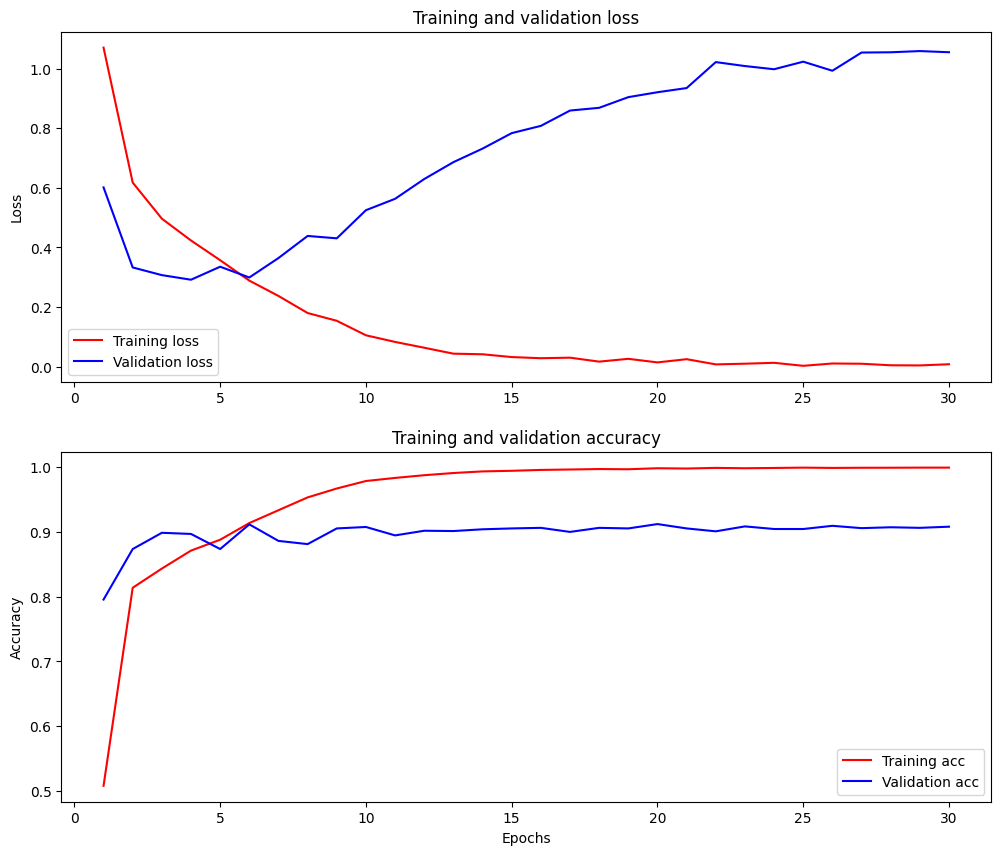

In [ ]:
history_dict = cnn_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 10))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'cnn_hate_speech'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

cnn_classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

# **Results for CNN**

In [ ]:
result =  cnn_classifier_model.predict(test_ds)
print(result.shape)

78/78 [==============================] - 9s 104ms/step
(2479, 3)


In [ ]:
result[0:2]

array([[0.00000192, 0.9999981 , 0.        ],
       [0.00000003, 1.        , 0.        ]], dtype=float32)

In [ ]:
# for tweet, classes in test_ds:
#     for i in classes:
#         print(i)

In [ ]:
classes = np.argmax(result, axis=-1)

In [ ]:
tweet = []
test_labels = []
predictions = []
for tweet, labels in test_ds.take(-1):
  tweet = tweet.numpy()
  test_labels.append(labels.numpy())
  predictions.append(cnn_classifier_model.predict(tweet))

1/1 [==============================] - 1s 702ms/step


In [ ]:
test_labels[0:2]

[array([2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 1, 1, 1, 1, 2]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1,
        1, 1, 2, 0, 1, 1, 1, 2, 2, 2])]

In [ ]:
predictions[0:2]

[array([[0.00000005, 0.00000802, 0.9999919 ],
        [0.00000025, 0.99999976, 0.        ],
        [0.00000014, 0.9999999 , 0.        ],
        [0.00000025, 0.99999976, 0.        ],
        [0.0000001 , 0.9999999 , 0.00000002],
        [0.00000036, 0.00013676, 0.9998629 ],
        [0.99999976, 0.00000024, 0.        ],
        [0.00000184, 0.9999982 , 0.00000002],
        [0.99924195, 0.00075781, 0.00000024],
        [0.00000003, 1.        , 0.        ],
        [0.00000215, 0.99999785, 0.        ],
        [0.0000001 , 0.9999999 , 0.        ],
        [0.00000006, 0.00000488, 0.9999951 ],
        [0.00000022, 0.99999976, 0.        ],
        [0.0000174 , 0.9999826 , 0.        ],
        [0.00000111, 0.99999356, 0.00000539],
        [0.00000001, 1.        , 0.        ],
        [0.00016049, 0.99983954, 0.00000001],
        [0.00000328, 0.99999666, 0.        ],
        [1.        , 0.00000003, 0.        ],
        [0.00000001, 1.        , 0.        ],
        [0.00003469, 0.9999653 , 0

In [ ]:
flatten_list = list(chain.from_iterable(predictions))
y_pred = np.argmax(flatten_list, axis=-1)

In [ ]:
type(y_pred)

numpy.ndarray

In [ ]:
y_test = np.array(list(chain.from_iterable(test_labels)))

In [ ]:
type(y_test)

numpy.ndarray

# **Confusion Matrix CNN**

In [ ]:
confusion_matrix(y_test, y_pred)

array([[  45,   89,    9],
       [  54, 1841,   25],
       [   5,   52,  359]])